In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import copy
from PIL import Image

import dlib
import time 
from tqdm import tqdm

In [5]:
base_path = "../Data/"

In [6]:
jaffe_data_path = base_path + 'JAFFE'
jaffe_images = glob.glob(jaffe_data_path+'/**/*.tiff', recursive=True)

In [7]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rescale_img(img, scale_factor=0.5):
    width, height = img.shape
    resized_height, resized_width = int(height*scale_factor), int(width*scale_factor)
    return resized_width, resized_height, Image.fromarray(img).resize((resized_height,resized_width))

def rescale_landmarks(landmarks, scale_factor=0.5):
    return landmarks * scale_factor

def rescale_img_landmarks(img, landmarks, scale_factor=0.5, size=None):

    if size:
        origin_width, origin_height = img.shape
        new_width, new_height = size
        
        width_factor = new_width / origin_width
        height_factor = new_height / origin_height
        
        new_landmarks = copy.deepcopy(landmarks)
        new_landmarks[:,0] = (new_landmarks[:,0] * width_factor)
        new_landmarks[:,1] = (new_landmarks[:,1] * height_factor)
                
        return (new_width, new_height, Image.fromarray(img).resize(size)), new_landmarks
    
    return rescale_img(img,scale_factor), rescale_landmarks(landmarks, scale_factor)

# (new_width, new_height, rescaled_img), rescaled_landmarks = rescale_img_landmarks(ck_dataframe.iloc[img_idx]['Image'],ck_dataframe.iloc[img_idx]['Landmarks'],size=(128,128))

# landmarks = [(part[0],part[1]) for part in rescaled_landmarks] 
# xs, ys = list(zip(*landmarks))
# plt.scatter(xs, ys, color='r')
# plt.imshow(rescaled_img)

# Train shape predictor on CK+ dataset, next apply it on JAFFE dataset.¶

In [16]:
ck_data_path = base_path + 'CK_CK+/CK+/cohn-kanade-images'
ck_landmarks_path = base_path + 'CK_CK+/CK+/Landmarks'

ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)
ck_landmarks_files = glob.glob(ck_landmarks_path+'/**/*.txt', recursive=True)

In [19]:
images_and_landmarks = {}

IMAGE_SIZE = (490,640)

with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
    for i, ck_image in enumerate(ck_image_files):
        subject = "_".join(ck_image.rsplit('/',3)[1:3])

        landmark_path = "/".join(ck_image.rsplit('/',3)[-3:])[:-4]
        landmark_file = ck_landmarks_path + '/' + landmark_path + '_landmarks.txt'

        landmarks = np.loadtxt(landmark_file)
        image = np.array(Image.open(ck_image))

        if image.shape != IMAGE_SIZE:
            pbar.update(1)
            continue

        (new_width, new_height, rescaled_img), rescaled_landmarks = rescale_img_landmarks(image,landmarks,scale_factor=0.2)
        
        drect = dlib.rectangle(0,0, image.shape[1], image.shape[0])
        dpoints = [dlib.point(landmark) for landmark in landmarks]

        objects = dlib.full_object_detections()
        objects.append(dlib.full_object_detection(drect, dpoints))

        images_and_landmarks[subject] = {
            "Image" : rescaled_img,
            "Landmarks" : rescaled_landmarks,
            "o_detection" : objects
        }
        
        pbar.update(1)

Processing entries: 100%|██████████| 10708/10708 [01:57<00:00, 91.16it/s] 


In [20]:
ck_dataframe = pd.DataFrame(images_and_landmarks).T
ck_dataframe.size

1659

# Show how dlib is (not) working

In [21]:
options = dlib.shape_predictor_training_options()
options.be_verbose = True

predictor = dlib.train_shape_predictor(ck_dataframe['Image'].values.tolist(), ck_dataframe['o_detection'].values.tolist(), options)

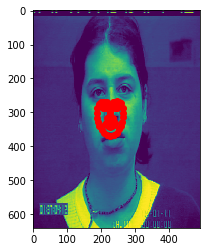

In [22]:
for image_path in ck_image_files[4:5]:
    im = Image.open(image_path).resize((490,640))
    imarray = np.array(im)
    
    detector = dlib.get_frontal_face_detector()
    rect = detector(imarray,1)[0]

    shape = predictor(imarray, rect)
    landmarks = [(part.x,part.y) for part in shape.parts()] 
    xs, ys = (list(zip(*landmarks)))

    plt.scatter(xs,ys, color='r')
    
    plt.imshow(imarray)
    break

In [19]:
img_idx = 5

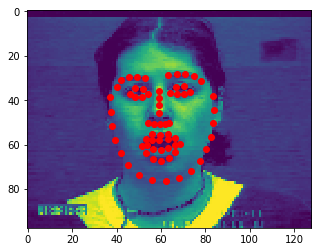

In [20]:
landmarks = ck_dataframe.iloc[img_idx]['Landmarks']
landmarks = [(part[0],part[1]) for part in landmarks] 
xs, ys = list(zip(*landmarks))
plt.scatter(xs, ys, color='r')
plt.imshow(ck_dataframe.iloc[img_idx]['Image'])

# Create the Convolutional Neural Network process

Create train,val & test data

In [41]:
batch_size = 32

In [68]:
import torch
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import RandomSampler

train_data_ratio = 0.6
val_data_ratio = 0.2
test_data_ratio = 1 - val_data_ratio - train_data_ratio

# Divide the hata into 60% train, 20% validation, and 20% test
addrs = np.stack(ck_dataframe['Image'].values).reshape(-1,1,98,128)
addrs = torch.Tensor(addrs)
labels = np.stack(ck_dataframe['Landmarks'].values)
labels = torch.Tensor(labels)

dataset_size = len(dataset)
dataset_indices = np.array(range(dataset_size))
np.random.shuffle(dataset_indices)

train_indices = dataset_indices[0:int(train_data_ratio*dataset_size)]
val_indices = dataset_indices[int(train_data_ratio*dataset_size):int(val_data_ratio*dataset_size)]
test_indices = dataset_indices[int(val_data_ratio*dataset_size):int(test_data_ratio*dataset_size)]

dataset = TensorDataset(addrs, labels)

train_data = dataset[train_indices]
val_data = dataset[val_indices]
test_data = dataset[test_indices]

train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

In [82]:
a,b = train_data
a[0].shape,b[0].shape

(torch.Size([1, 98, 128]), torch.Size([68, 2]))

In [83]:
dataiter = iter(train_loader)
images,landmarks = dataiter.next()

# landmarks = [(part[0],part[1]) for part in np.fliplr(landmarks[0].numpy())] 
# xs, ys = list(zip(*landmarks))
# plt.scatter(xs, ys, color='r')

RuntimeError: Traceback (most recent call last):
  File "/miniconda2/envs/PGround/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/miniconda2/envs/PGround/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 209, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 5 and 4 at /Users/soumith/mc3build/conda-bld/pytorch_1549597882250/work/aten/src/TH/generic/THTensorMoreMath.cpp:1298


In [ ]:
## Compute CNN output size

def outputSize(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

    return(output)

In [ ]:
import torch
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        
        self.conv1 = nn.Conv2d(1, 32, 3, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(256*6*7, 1024)
        self.fc2 = nn.Linear(1024, 68 * 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))

        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))

        x = self.pool(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = self.pool(F.relu(self.conv7(x)))
        x = F.relu(self.conv8(x))

        x = x.view(-1, 256*6*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 68, 2)
        
        return x

In [ ]:
net = SimpleCNN()

In [ ]:
import torch.optim as optim
from torch import nn

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
num_iter = 50

for epoch in range(num_iter):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
#     for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
    
#       zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs)
        loss = torch.sqrt(criterion(outputs, labels))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 11 == 10:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
for image in jaffe_images:
    im = Image.open(image)
    im.show()
    break